In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask,jsonify

# Reflect Tables into SQLAlchemy ORM

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the last date recorded in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [14]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns =["date", "prcp"])
precipitation_df = precipitation_df.set_index("date")

# Sort the dataframe by date
precipitation_df.sort_values(by=["date"])

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


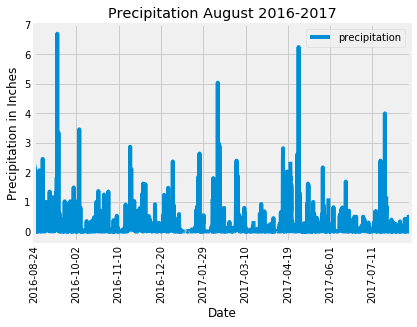

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.title("Precipitation August 2016-2017")
plt.legend(["precipitation"])
plt.xticks(rotation=90)


plt.savefig("precipitation.png")
plt.show()

In [18]:
# Get summary statistics of the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
stations

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

for row in active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp_stats = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
temperature = session.query(*temp_stats).\
    filter(Measurement.station == active_stations[0][0]).all()
print(temperature)

[(54.0, 85.0, 71.66378066378067)]


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_df = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
    filter(Measurement.date > last_year).\
    filter(Measurement.station == active_stations[0][0]).all()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-24', '2017-08-23"'))

[(53.0, 72.69282284559009, 86.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

past_year_temp_stats = print(calc_temps("2016-08-24","2017-08-23"))


[(58.0, 74.57894736842105, 87.0)]
